# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
import os;
from os.path import join as pathjoin;

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

import re;
import json;
import codecs;
from collections import defaultdict;

from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn import preprocessing
from sklearn.preprocessing import normalize, MaxAbsScaler, RobustScaler;
from sklearn.decomposition import PCA;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model;
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier

 
#
from sklearn import feature_selection;
from sklearn import ensemble;

from sklearn.model_selection import train_test_split;
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import seaborn as sns;
sns.set(color_codes=True);

In [3]:
import spacy
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""  #spacy causes a bug on pandas and this code fix it

In [4]:
import platform;
import sklearn;
import scipy;

print("|%-15s|%-40s|"%("PACK","VERSION"))
print("|%-15s|%-40s|"%('-'*15,'-'*40))
print('\n'.join(
    "|%-15s|%-40s|" % (pack, version)
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','seaborn','spacy'],
        [platform.platform(), np.__version__, scipy.__version__, sklearn.__version__, sns.__version__, spacy.__version__])

))

|PACK           |VERSION                                 |
|---------------|----------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit         |
|NumPy          |1.15.4                                  |
|SciPy          |1.1.0                                   |
|Scikit-Learn   |0.20.1                                  |
|seaborn        |0.9.0                                   |
|spacy          |2.0.16                                  |


In [5]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

In [6]:
#externalizing codes that is used in many notebooks and it is not experiment specific
import pan
#convert a sparse matrix into a dense for being used on PCA
from skleanExtensions import DenseTransformer;

#convert an array of text into an array of tokenized texts each token must contain text, tag_, pos_, dep_
from skleanExtensions import POSTagTransformer

### paths configuration

In [7]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [8]:
problems = pan.readCollectionsOfProblems(inputDir);

In [9]:
print(problems[0]['problem'])
print(problems[0].keys())

problem00001
dict_keys(['problem', 'language', 'encoding', 'candidates_folder_count', 'candidates', 'unknown'])


In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


### Tagging

Since tagged text will be used in many noteboook, this code create a cache to avoid retagging every time.

In [11]:
def cachingPOSTAG(problem, taggingVersion='TAG'):
    import json;
    print ("Tagging: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    if not os.path.exists('POSTAG_cache'):
        os.makedirs('POSTAG_cache');
    
    _id = problem['problem']+problem['language'];
    filename = os.path.join('POSTAG_cache',taggingVersion+'_'+_id+'.json')
    if not os.path.exists(filename):
        lang = problem['language'];
        if lang == 'sp':
            lang = 'es';
        elif lang =='pl':
            print(lang, ' not supported');
            return ;

        train_docs, train_labels, _   = zip(*problem['candidates'])
        problem['training_docs_size'] = len(train_docs);
        test_docs, _, test_filename   = zip(*problem['unknown'])

        t0 = time()
        tagger = POSTagTransformer(language=lang);
        train_docs = tagger.fit_transform(train_docs);
        test_docs = tagger.fit_transform(test_docs);
        
        print("Annotation time %0.3fs" % (time() - t0))
        
        with open(filename,'w') as f:
            json.dump({
                'train':train_docs,
                'train_labels':train_labels,
                'test':test_docs,
                'test_filename':test_filename
            },f);
    else:
        with open(filename,'r') as f:
            data = json.load(f);

            train_docs = data['train'];
            train_labels = data['train_labels'];
            test_docs  = data['test'];
            test_filename = data['test_filename'];
    print('tagged')
    return train_docs, train_labels, test_docs, test_filename;

for problem in problems:
    cachingPOSTAG(problem)

Tagging: problem00001,  language: en,  tagged
Tagging: problem00002,  language: en,  tagged
Tagging: problem00003,  language: fr,  tagged
Tagging: problem00004,  language: fr,  tagged
Tagging: problem00005,  language: it,  tagged
Tagging: problem00006,  language: it,  tagged
Tagging: problem00007,  language: pl,  pl  not supported
Tagging: problem00008,  language: pl,  pl  not supported
Tagging: problem00009,  language: sp,  tagged
Tagging: problem00010,  language: sp,  tagged


In [12]:
train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

Tagging: problem00010,  language: sp,  tagged


In [13]:
class FilterTagTransformer(BaseEstimator):
    def __init__(self,token='POS', parts=None):
        self.token = token;
        self.parts = parts;
            

    def transform(self, X, y=None):
        """ Return An array of tokens 
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_tokens]
            Array documents, where each document consists of a list of node
            and each node consist of a token and its correspondent tag
            
            [
            [('a','TAG1'),('b','TAG2')],
            [('a','TAG1')]
            ]
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        t0 = time()
        print('start filter', end=' ')
        if self.token == 'TAG':
            X = [' '.join([d[1].split('__')[0] for d in doc]) for doc in X]
        elif self.token == 'POS':
            if self.parts is None:
                X = [' '.join([d[2] for d in doc]) for doc in X];
            else:
                X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        elif self.token == 'DEP':
            X = [' '.join([d[3] for d in doc]) for doc in X]
        elif self.token == 'word_POS':
            if self.parts is None:
                X = [' '.join([d[0]+'/'+d[2] for d in doc]) for doc in X]
        elif self.token == 'filter':
            X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        else:
            X = [' '.join([d[0] for d in doc]) for doc in X]
        
        print(" %0.3fs" % (time() - t0))
        return np.array(X);       

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

### analisando os demais parametros

In [14]:
class FilterTagTransformer(BaseEstimator):
    def __init__(self,token='POS', parts=None):
        self.token = token;
        self.parts = parts;

    def transform(self, X, y=None):
        """ Return An array of tokens 
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_tokens]
            Array documents, where each document consists of a list of node
            and each node consist of a token and its correspondent tag
            
            [
            [('a','TAG1'),('b','TAG2')],
            [('a','TAG1')]
            ]
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if self.token == 'TAG':
            X = [' '.join([d[1].split('__')[0] for d in doc]) for doc in X]
        elif self.token == 'POS':
            if self.parts is None:
                X = [' '.join([d[2] for d in doc]) for doc in X];
            else:
                X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        elif self.token == 'DEP':
            X = [' '.join([d[3] for d in doc]) for doc in X]
        elif self.token == 'word_POS':
            if self.parts is None:
                X = [' '.join([d[0]+'/'+d[2] for d in doc]) for doc in X]
        elif self.token == 'filter':
            if self.parts is None:
                X = [' '.join([d[2] for d in doc]) for doc in X];
            else:
                X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        else:
            X = [' '.join([d[0] for d in doc]) for doc in X]
        
        return np.array(X);       

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [37]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    lang = problem['language'];
    if lang == 'sp':
        lang = 'es';
    elif lang =='pl':
        print(lang, ' not supported');
        return None,None,None,None;
    
    train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

    t0 = time()
    
    pipeline = Pipeline([
        ('filter',FilterTagTransformer(token='POS')),
        ('vect', CountVectorizer(
                                   min_df=0.01,
                                   lowercase=False
                                  )),
        ('tfidf',  TfidfTransformer()),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range' :((1,1),(1,2),(1,3),(1,5)),
        'tfidf__use_idf'     :(True, False),
        'tfidf__sublinear_tf':(True, False),
        'tfidf__norm':('l1','l2'),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=4,
                               iid=False,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #calculating the performance using PAN evaluation code
    f1,precision,recall,accuracy=pan.evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [18]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b, e = runML(problem);
        if r is None:
            continue;
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  Tagging: problem00001,  language: en,  tagged
Gridsearh 326.799s Best score: 0.566
Best parameters set:
	tfidf__norm: 'l1'
	tfidf__sublinear_tf: False
	tfidf__use_idf: False
	vect__ngram_range: (1, 5)

Problem: problem00002,  language: en,  Tagging: problem00002,  language: en,  tagged
Gridsearh 80.293s Best score: 0.853
Best parameters set:
	tfidf__norm: 'l1'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True
	vect__ngram_range: (1, 3)

Problem: problem00003,  language: fr,  Tagging: problem00003,  language: fr,  tagged
Gridsearh 354.106s Best score: 0.519
Best parameters set:
	tfidf__norm: 'l1'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True
	vect__ngram_range: (1, 3)

Problem: problem00004,  language: fr,  Tagging: problem00004,  language: fr,  tagged
Gridsearh 87.292s Best score: 0.645
Best parameters set:
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	tfidf__use_idf: False
	vect__ngram_range: (1, 5)

Problem: problem00005,  language: it,  Tag

In [20]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [21]:
df

,problem-name,language,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,0.3180,0.3250,0.3950,0.4860
1,problem00002,en,0.6060,0.6440,0.7000,0.6670
2,problem00003,fr,0.3530,0.3720,0.4140,0.4080
3,problem00004,fr,0.4080,0.4500,0.4000,0.4760
4,problem00005,it,0.3460,0.4110,0.4650,0.3000
5,problem00006,it,0.3800,0.4530,0.6420,0.4570
6,problem00009,sp,0.4440,0.4530,0.5840,0.4620
7,problem00010,sp,0.5060,0.5120,0.5200,0.5780


In [22]:
df[['macro-f1']].mean()

macro-f1   0.4201
dtype: float64

In [23]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [25]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = int(re.sub('\D','',result[i]['problem-name']));
    temp['language'] = languages[result[i]['language']]
    dfCV = dfCV.append(temp);

for p in [
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score',
    'split1_test_score',
    'split2_test_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_vect__ngram_range',
    'param_tfidf__sublinear_tf',
    'param_tfidf__norm',
    'mean_test_score',   
    'std_test_score',

    'split0_test_score',
    'split1_test_score',
    'split2_test_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_vect__ngram_range':'ngram_range',
    'param_tfidf__sublinear_tf':'sublinear_tf',
    'param_tfidf__smooth_idf':'smooth_idf',
    'param_tfidf__norm':'norm'
},inplace=True);

#print('\',\n\''.join(dfCV.columns))


In [26]:
dfCV.head()

,problem,language,rank_test_score,ngram_range,sublinear_tf,norm,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,mean_score_time,mean_fit_time,std_fit_time,std_score_time,std_train_score
0,1,inglesa,31,"(1, 1)",True,l1,0.1548,0.0665,0.1260,0.1772,0.0675,0.0244,0.0704,0.0045,0.0072,0.0120
1,1,inglesa,22,"(1, 2)",True,l1,0.4470,0.1209,0.3217,0.3510,0.4902,0.0512,0.1474,0.0229,0.0231,0.0000
2,1,inglesa,9,"(1, 3)",True,l1,0.5247,0.1053,0.4417,0.4436,0.5136,0.0757,0.2846,0.0227,0.0226,0.0000
3,1,inglesa,2,"(1, 5)",True,l1,0.5657,0.1473,0.4626,0.4583,0.5252,0.1634,0.9252,0.0540,0.0442,0.0000
4,1,inglesa,30,"(1, 1)",True,l1,0.1554,0.0667,0.1260,0.1797,0.0675,0.0310,0.0878,0.0251,0.0173,0.0134


## Saving the model

In [27]:
dfCV.to_csv('PANAA2018_POS.csv', index=False)

In [28]:
dfCV = pd.read_csv('PANAA2018_POS.csv', na_values='')

In [29]:
import pickle;
with open("PAN_AA_2018_POS.pkl","wb") as f:
    pickle.dump(estimators,f)

## understanding the model with reports

Podemos ver que para um mesmo problema mais de uma configuração é possível

In [30]:
print(' | '.join(best_parameters[0]['vect'].get_feature_names()[0:20]))

ADJ | ADJ ADJ | ADJ ADJ ADJ | ADJ ADJ ADJ ADJ | ADJ ADJ ADJ ADJ NOUN | ADJ ADJ ADJ NOUN | ADJ ADJ ADJ NOUN CCONJ | ADJ ADJ ADJ NOUN NOUN | ADJ ADJ ADJ NOUN PUNCT | ADJ ADJ ADJ NOUN VERB | ADJ ADJ ADJ PUNCT | ADJ ADJ ADP | ADJ ADJ ADP ADJ | ADJ ADJ ADP ADJ NOUN | ADJ ADJ ADP DET | ADJ ADJ ADP DET NOUN | ADJ ADJ ADP PRON | ADJ ADJ ADP PRON VERB | ADJ ADJ ADV | ADJ ADJ ADV PUNCT


In [31]:
(dfCV[dfCV.rank_test_score == 1]).drop_duplicates()[
    ['problem',
     'language',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
     'norm']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf'
], ascending=[True, False,True,False,False])

,problem,language,mean_test_score,std_test_score,ngram_range,sublinear_tf,norm
15,1,inglesa,0.5659,0.1452,"(1, 5)",False,l1
34,2,inglesa,0.8533,0.1379,"(1, 3)",True,l1
38,2,inglesa,0.8533,0.1379,"(1, 3)",True,l1
50,2,inglesa,0.8533,0.1379,"(1, 3)",True,l2
54,2,inglesa,0.8533,0.1379,"(1, 3)",True,l2
66,3,francesa,0.5189,0.0456,"(1, 3)",True,l1
119,4,francesa,0.6450,0.0744,"(1, 5)",True,l2
147,5,italiana,0.4130,0.0755,"(1, 5)",True,l2
162,6,italiana,0.7850,0.1253,"(1, 3)",True,l1
211,9,espanhola,0.5704,0.0663,"(1, 5)",True,l2


In [32]:
dfCV.pivot_table(
            index=['problem','language'],
            columns=['norm','sublinear_tf', 'ngram_range'],
            values='mean_test_score'
        )

norm                  l1                                                   \
sublinear_tf       False                       True                         
ngram_range       (1, 1) (1, 2) (1, 3) (1, 5) (1, 1) (1, 2) (1, 3) (1, 5)   
problem language                                                            
1       inglesa   0.2976 0.5039 0.5357 0.5604 0.1551 0.4388 0.5211 0.5522   
2       inglesa   0.5700 0.8369 0.8336 0.8336 0.4226 0.7125 0.8533 0.8126   
3       francesa  0.2001 0.3780 0.4438 0.4672 0.0917 0.3486 0.5054 0.4760   
4       francesa  0.4483 0.5650 0.5233 0.5558 0.3350 0.3251 0.6067 0.5708   
5       italiana  0.1834 0.3276 0.3449 0.3671 0.0777 0.2425 0.3626 0.3901   
6       italiana  0.6950 0.6067 0.6400 0.6536 0.3200 0.6686 0.7425 0.6852   
9       espanhola 0.1987 0.4660 0.4903 0.5440 0.0597 0.4184 0.5336 0.5611   
10      espanhola 0.4283 0.6650 0.5050 0.6667 0.1750 0.5102 0.5050 0.6400   

norm                  l2                                                   
sublinear_tf       False                       True                        
ngram_range       (1, 1) (1, 2) (1, 3) (1, 5) (1, 1) (1, 2) (1, 3) (1, 5)  
problem language                                                           
1       inglesa   0.2963 0.5076 0.5204 0.5113 0.1562 0.4357 0.4970 0.5382  
2       inglesa   0.5700 0.8352 0.8336 0.7972 0.4226 0.7125 0.8533 0.7726  
3       francesa  0.1980 0.3965 0.4540 0.4335 0.0936 0.3617 0.4990 0.4850  
4       francesa  0.4433 0.5483 0.5567 0.5208 0.3600 0.3267 0.6233 0.6242  
5       italiana  0.1792 0.3342 0.3398 0.3686 0.0796 0.2498 0.3846 0.4084  
6       italiana  0.6850 0.6067 0.6200 0.6669 0.3200 0.6427 0.7042 0.6550  
9       espanhola 0.1830 0.4473 0.4905 0.5005 0.0622 0.4109 0.5392 0.5492  
10      espanhola 0.4017 0.6650 0.5126 0.5783 0.1750 0.5027 0.5050 0.6567

O score retornado vem do conjunto de teste da validação cruzada e não do conjunto de testes

In [33]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV.pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llllrrrr}
\toprule
 & & & ngram\_range & (1, 1) & (1, 2) & (1, 3) & (1, 5) \\
problem & language & sublinear\_tf & norm & & & & \\
\midrule
1 & inglesa & False & l1 & 0.2976 & 0.5039 & 0.5357 & 0.5604 \\
 & & & l2 & 0.2963 & 0.5076 & 0.5204 & 0.5113 \\
 & & True & l1 & 0.1551 & 0.4388 & 0.5211 & 0.5522 \\
 & & & l2 & 0.1562 & 0.4357 & 0.4970 & 0.5382 \\
2 & inglesa & False & l1 & 0.5700 & 0.8369 & 0.8336 & 0.8336 \\
 & & & l2 & 0.5700 & 0.8352 & 0.8336 & 0.7972 \\
 & & True & l1 & 0.4226 & 0.7125 & 0.8533 & 0.8126 \\
 & & & l2 & 0.4226 & 0.7125 & 0.8533 & 0.7726 \\
3 & francesa & False & l1 & 0.2001 & 0.3780 & 0.4438 & 0.4672 \\
 & & & l2 & 0.1980 & 0.3965 & 0.4540 & 0.4335 \\
 & & True & l1 & 0.0917 & 0.3486 & 0.5054 & 0.4760 \\
 & & & l2 & 0.0936 & 0.3617 & 0.4990 & 0.4850 \\
4 & francesa & False & l1 & 0.4483 & 0.5650 & 0.5233 & 0.5558 \\
 & & & l2 & 0.4433 & 0.5483 & 0.5567 & 0.5208 \\
 & & True & l

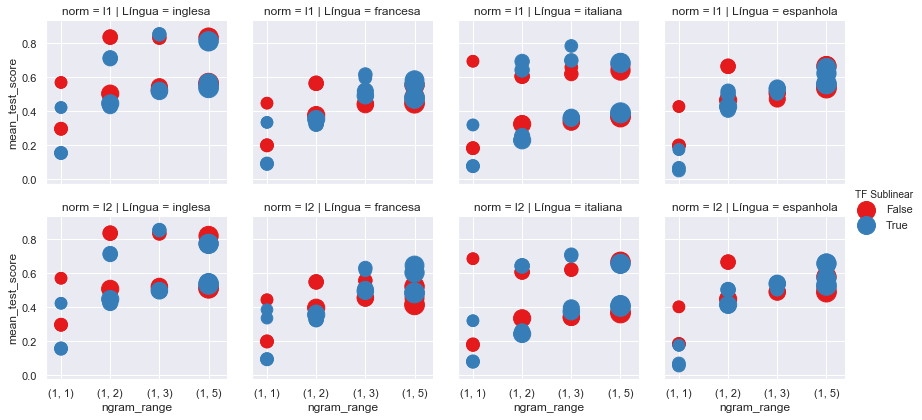

In [34]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="norm", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score",s=d.std_test_score.values).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


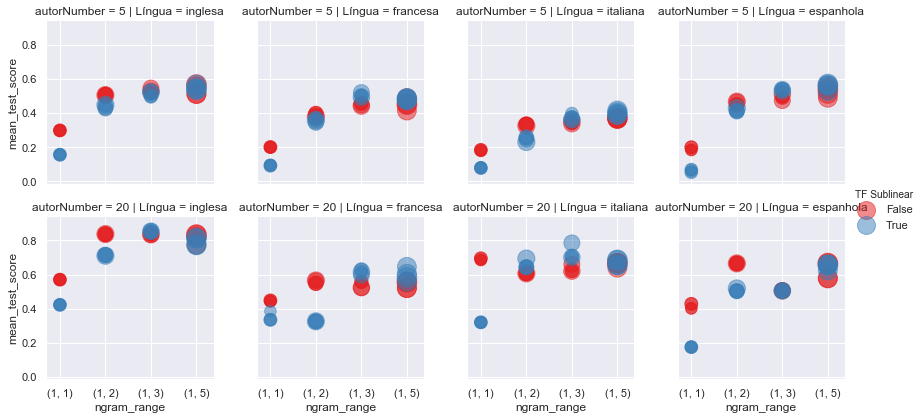

In [35]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

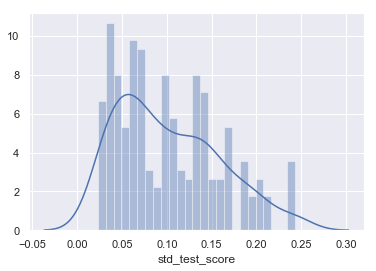

In [36]:
sns.distplot(dfCV.std_test_score, bins=25);

In [38]:
import statsmodels.api as sm

In [39]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d.norm=d.norm.apply(lambda x: 1 if x=='l1' else 0)

d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language'])

In [40]:
d.describe()

,mean_test_score,sublinear_tf,norm,autorNumber,ngram_max,language_espanhola,language_francesa,language_inglesa,language_italiana
count,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000
mean,0.4810,0.5000,0.5000,12.5000,2.7500,0.2500,0.2500,0.2500,0.2500
std,0.1889,0.5010,0.5010,7.5147,1.4819,0.4339,0.4339,0.4339,0.4339
min,0.0520,0.0000,0.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,0.3651,0.0000,0.0000,5.0000,1.7500,0.0000,0.0000,0.0000,0.0000
50%,0.5039,0.5000,0.5000,12.5000,2.5000,0.0000,0.0000,0.0000,0.0000
75%,0.6067,1.0000,1.0000,20.0000,3.5000,0.2500,0.2500,0.2500,0.2500
max,0.8533,1.0000,1.0000,20.0000,5.0000,1.0000,1.0000,1.0000,1.0000


In [41]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     76.83
Date:                Tue, 05 Feb 2019   Prob (F-statistic):           1.64e-58
Time:                        14:53:35   Log-Likelihood:                 211.55
No. Observations:                 256   AIC:                            -407.1
Df Residuals:                     248   BIC:                            -378.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf          -0.0486      0.013     -3.614      0.000      -0.075      -0.022
norm                   0.0054      0.013      0.402      0.688      -0.021       0.032
autorNumber            0.0142      0.001     15.866      0.000       0.012       0.016
ngram_max              0.0630      0.005     13.850      0.000       0.054       0.072
language_espanhola     0.1252      0.024      5.324      0.000       0.079       0.172
language_francesa      0.1008      0.024      4.286      0.000       0.054       0.147
language_inglesa       0.2550      0.024     10.841      0.000       0.209       0.301
language_italiana      0.1254      0.024      5.331      0.000       0.079       0.172
==============================================================================
Omnibus:                        7.946   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                4.422
Skew:                           0.098   Prob(JB):                        0.110
Kurtosis:                       2.387   Cond. No.                         91.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

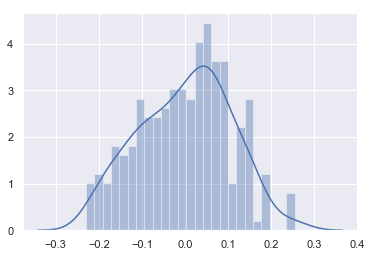

In [42]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

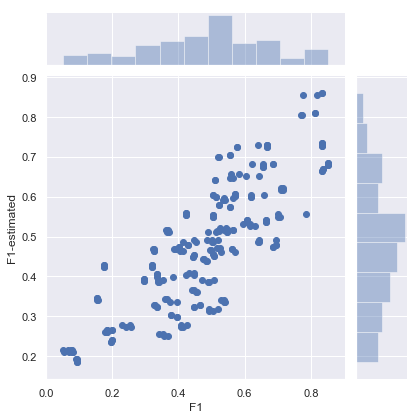

In [43]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));

#  tests

In [47]:
def d(estimator, n_features=5):
    from IPython.display import Markdown, display, HTML
    names = np.array(estimator.named_steps['vect'].get_feature_names());
    classes_ = estimator.named_steps['clf'].classes_;
    weights = estimator.named_steps['clf'].coef_;
    
    def tag(tag, content, attrib=''):
        if attrib != '':
            attrib = ' style="' + attrib+'"'; 
        return ''.join(['<',tag,attrib,' >',content,'</',tag,'>']);
    
    def color(baseColor, intensity):
        r,g,b = baseColor[0:2],baseColor[2:4],baseColor[4:6]
        r,g,b = int(r, 16), int(g, 16), int(b, 16)
        
        f= (1-np.abs(intensity))/2;
        r = r + int((255-r)*f)
        g = g + int((255-g)*f)
        b = b + int((255-b)*f)
        rgb = '#%02x%x%x' % (r, g, b);
        #print(baseColor,rgb,r,g,b,intensity,f)
        return rgb
    
    
    spanStyle ='border-radius: 5px;margin:4px;padding:3px; color:#FFF !important;';
    
    lines = '<table>'+tag('thead',tag('th','Classes')+tag('th','positive')+tag('th','negative'))
    lines += '<tbody>'
    for i,c in enumerate(weights):
        c = np.round(c / np.abs(c).max(),2);
        positive = names[np.argsort(-c)][:n_features];
        positiveV = c[np.argsort(-c)][:n_features]
        negative = names[np.argsort(c)][:n_features];
        negativeV = c[np.argsort(c)][:n_features]
        
        lines += tag('tr',
                     tag('td', re.sub('\D0*','',classes_[i]))
                     + tag('td',''.join([tag('span',d.upper()+' '+str(v),spanStyle+'background:'+color('51A3DD',v)) for d,v in zip(positive,positiveV)]))
                     + tag('td',''.join([tag('span',d.upper()+' '+str(v),spanStyle+'background:'+color('DD5555',v)) for d,v in zip(negative,negativeV)]))
                    )
    lines+= '</tbody></table>'
        
    display(HTML(lines))
    #print(lines)
        
d(estimators[7])

1,ADJ ADJ 1.0ADJ ADJ ADJ ADP PRON 0.36ADJ ADJ ADP NOUN 0.21ADJ ADJ ADP 0.16ADJ ADJ ADP PROPN PUNCT 0.11,ADJ -0.5ADJ ADJ ADP VERB -0.19ADJ ADJ ADJ -0.16ADJ ADJ ADP PRON PUNCT -0.16ADJ ADJ PUNCT ADP -0.12
2,ADJ ADJ ADJ 1.0ADJ ADJ ADP NOUN ADJ 0.84ADJ ADJ ADP 0.62ADJ ADJ PRON VERB 0.59ADJ ADJ CONJ ADV 0.46,ADJ ADJ ADP NOUN PUNCT -0.7ADJ ADJ ADJ ADP PRON -0.59ADJ ADJ ADJ ADP -0.51ADJ ADJ PUNCT -0.51ADJ ADJ NOUN PROPN PUNCT -0.46
3,ADJ ADJ CONJ 0.37ADJ ADJ ADP DET NUM 0.3ADJ ADJ ADP DET NOUN 0.29ADJ ADJ AUX ADJ ADP 0.28ADJ ADJ ADP PRON PUNCT 0.28,ADJ ADJ ADP -1.0ADJ ADJ ADJ ADP PRON -0.87ADJ ADJ AUX -0.75ADJ ADJ CONJ ADV DET -0.69ADJ ADJ ADP VERB ADP -0.64
4,ADJ ADJ ADJ ADP 1.0ADJ 0.97ADJ ADJ ADJ 0.56ADJ ADJ ADP NOUN PUNCT 0.55ADJ ADJ ADP VERB 0.54,ADJ ADJ PRON VERB DET -0.65ADJ ADJ NOUN PROPN -0.47ADJ ADJ PRON VERB -0.36ADJ ADJ CONJ ADV -0.26ADJ ADJ ADP DET NUM -0.25
5,ADJ ADJ ADJ ADP PRON 0.8ADJ ADJ ADP DET 0.72ADJ ADJ CONJ ADV DET 0.71ADJ ADJ NOUN PROPN PUNCT 0.65ADJ ADJ ADP VERB ADP 0.44,ADJ ADJ -1.0ADJ ADJ ADJ -0.8ADJ ADJ ADP DET NOUN -0.4ADJ ADJ ADP NOUN ADJ -0.4ADJ ADJ CONJ -0.34


In [48]:
%%HTML
<table><tbody><tr><th>POS</th><th>Description</th><th>Examples</th></tr><tr >
<td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text u-text-small">adjective</td><td class="c-table__cell u-text u-text-small"><em>big, old, green, incomprehensible, first</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text u-text-small">adposition</td><td class="c-table__cell u-text u-text-small"><em>in, to, during</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text u-text-small">adverb</td><td class="c-table__cell u-text u-text-small"><em>very, tomorrow, down, where, there</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text u-text-small">auxiliary</td><td class="c-table__cell u-text u-text-small"><em>is, has (done), will (do), should (do)</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text u-text-small">conjunction</td><td class="c-table__cell u-text u-text-small"><em>and, or, but</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CCONJ</code></td><td class="c-table__cell u-text u-text-small">coordinating conjunction</td><td class="c-table__cell u-text u-text-small"><em>and, or, but</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text u-text-small">determiner</td><td class="c-table__cell u-text u-text-small"><em>a, an, the</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text u-text-small">interjection</td><td class="c-table__cell u-text u-text-small"><em>psst, ouch, bravo, hello</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text u-text-small">noun</td><td class="c-table__cell u-text u-text-small"><em>girl, cat, tree, air, beauty</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text u-text-small">numeral</td><td class="c-table__cell u-text u-text-small"><em>1, 2017, one, seventy-seven, IV, MMXIV</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text u-text-small">particle</td><td class="c-table__cell u-text u-text-small"><em>'s, not, </em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text u-text-small">pronoun</td><td class="c-table__cell u-text u-text-small"><em>I, you, he, she, myself, themselves, somebody</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text u-text-small">proper noun</td><td class="c-table__cell u-text u-text-small"><em>Mary, John, London, NATO, HBO</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text u-text-small">punctuation</td><td class="c-table__cell u-text u-text-small"><em>., (, ), ?</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SCONJ</code></td><td class="c-table__cell u-text u-text-small">subordinating conjunction</td><td class="c-table__cell u-text u-text-small"><em>if, while, that</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text u-text-small">symbol</td><td class="c-table__cell u-text u-text-small"><em>$, %, §, ©, +, −, ×, ÷, =, :), 😝</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text u-text-small">verb</td><td class="c-table__cell u-text u-text-small"><em>run, runs, running, eat, ate, eating</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text u-text-small">other</td><td class="c-table__cell u-text u-text-small"><em>sfpksdpsxmsa</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text u-text-small">space</td></tr></tbody></table>

POS,Description,Examples
ADJ,adjective,"big, old, green, incomprehensible, first"
ADP,adposition,"in, to, during"
ADV,adverb,"very, tomorrow, down, where, there"
AUX,auxiliary,"is, has (done), will (do), should (do)"
CONJ,conjunction,"and, or, but"
CCONJ,coordinating conjunction,"and, or, but"
DET,determiner,"a, an, the"
INTJ,interjection,"psst, ouch, bravo, hello"
NOUN,noun,"girl, cat, tree, air, beauty"
NUM,numeral,"1, 2017, one, seventy-seven, IV, MMXIV"


In [49]:
%%HTML
<h1>English</h1>

<table class="c-table o-block"><tbody><tr class="c-table__row c-table__row--head"><th class="c-table__head-cell u-text-label">Tag</th><th class="c-table__head-cell u-text-label">POS</th><th class="c-table__head-cell u-text-label">Morphology</th><th class="c-table__head-cell u-text-label">Description</th></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>-LRB-</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code> <code>PunctSide=ini</code></td><td class="c-table__cell u-text u-text-small">left round bracket</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>-RRB-</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">right round bracket</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>,</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=comm</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, comma</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>:</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">punctuation mark, colon or ellipsis</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>.</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=peri</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, sentence closer</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>''</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">closing quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>""</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">closing quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>#</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"> <code>SymType=numbersign</code></td><td class="c-table__cell u-text u-text-small">symbol, number sign</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>``</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=ini</code></td><td class="c-table__cell u-text u-text-small">opening quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>$</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"> <code>SymType=currency</code></td><td class="c-table__cell u-text u-text-small">symbol, currency</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADD</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">email</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>AFX</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Hyph=yes</code></td><td class="c-table__cell u-text u-text-small">affix</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>BES</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">auxiliary "be"</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CC</code></td><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text"> <code>ConjType=coor</code></td><td class="c-table__cell u-text u-text-small">conjunction, coordinating</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CD</code></td><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text"> <code>NumType=card</code></td><td class="c-table__cell u-text u-text-small">cardinal number</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>DT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>determiner</code></td><td class="c-table__cell u-text u-text-small"></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>EX</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>AdvType=ex</code></td><td class="c-table__cell u-text u-text-small">existential there</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>FW</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"> <code>Foreign=yes</code></td><td class="c-table__cell u-text u-text-small">foreign word</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>GW</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">additional word in multi-word expression</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>HVS</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">forms of "have"</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>HYPH</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=dash</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, hyphen</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>IN</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">conjunction, subordinating or preposition</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJ</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=pos</code></td><td class="c-table__cell u-text u-text-small">adjective</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJR</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=comp</code></td><td class="c-table__cell u-text u-text-small">adjective, comparative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJS</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=sup</code></td><td class="c-table__cell u-text u-text-small">adjective, superlative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>LS</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>NumType=ord</code></td><td class="c-table__cell u-text u-text-small">list item marker</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>MD</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbType=mod</code></td><td class="c-table__cell u-text u-text-small">verb, modal auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NFP</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">superfluous punctuation</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NIL</code></td><td class="c-table__cell u-text"><code></code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">missing tag</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NN</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>Number=sing</code></td><td class="c-table__cell u-text u-text-small">noun, singular or mass</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNP</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"> <code>NounType=prop</code> <code>Number=sign</code></td><td class="c-table__cell u-text u-text-small">noun, proper singular</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNPS</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"> <code>NounType=prop</code> <code>Number=plur</code></td><td class="c-table__cell u-text u-text-small">noun, proper plural</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNS</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>Number=plur</code></td><td class="c-table__cell u-text u-text-small">noun, plural</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PDT</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>AdjType=pdt</code> <code>PronType=prn</code></td><td class="c-table__cell u-text u-text-small">predeterminer</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>POS</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>Poss=yes</code></td><td class="c-table__cell u-text u-text-small">possessive ending</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRP</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code></td><td class="c-table__cell u-text u-text-small">pronoun, personal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRP$</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code> <code>Poss=yes</code></td><td class="c-table__cell u-text u-text-small">pronoun, possessive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RB</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=pos</code></td><td class="c-table__cell u-text u-text-small">adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RBR</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=comp</code></td><td class="c-table__cell u-text u-text-small">adverb, comparative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RBS</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=sup</code></td><td class="c-table__cell u-text u-text-small">adverb, superlative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RP</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">adverb, particle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>_SP</code></td><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">space</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">symbol</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>TO</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>PartType=inf</code> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">infinitival to</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>UH</code></td><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">interjection</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VB</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">verb, base form</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBD</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=past</code></td><td class="c-table__cell u-text u-text-small">verb, past tense</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBG</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=part</code> <code>Tense=pres</code> <code>Aspect=prog</code></td><td class="c-table__cell u-text u-text-small">verb, gerund or present participle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBN</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=part</code> <code>Tense=past</code> <code>Aspect=perf</code></td><td class="c-table__cell u-text u-text-small">verb, past participle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBP</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=pres</code></td><td class="c-table__cell u-text u-text-small">verb, non-3rd person singular present</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBZ</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=pres</code> <code>Number=sing</code> <code>Person=3</code></td><td class="c-table__cell u-text u-text-small">verb, 3rd person singular present</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WDT</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-determiner</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WP</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-pronoun, personal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WP$</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Poss=yes PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-pronoun, possessive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WRB</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>XX</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">unknown</td></tr></tbody></table>

Tag,POS,Morphology,Description
-LRB-,PUNCT,PunctType=brck PunctSide=ini,left round bracket
-RRB-,PUNCT,PunctType=brck PunctSide=fin,right round bracket
",",PUNCT,PunctType=comm,"punctuation mark, comma"
:,PUNCT,,"punctuation mark, colon or ellipsis"
.,PUNCT,PunctType=peri,"punctuation mark, sentence closer"
'',PUNCT,PunctType=quot PunctSide=fin,closing quotation mark
"""""",PUNCT,PunctType=quot PunctSide=fin,closing quotation mark
#,SYM,SymType=numbersign,"symbol, number sign"
``,PUNCT,PunctType=quot PunctSide=ini,opening quotation mark
$,SYM,SymType=currency,"symbol, currency"
